In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3: 
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('Kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim /long_dim
    
    new_shape = tf.cast(shape *scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

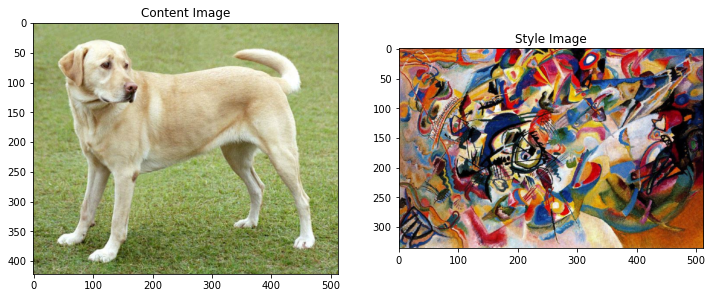

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

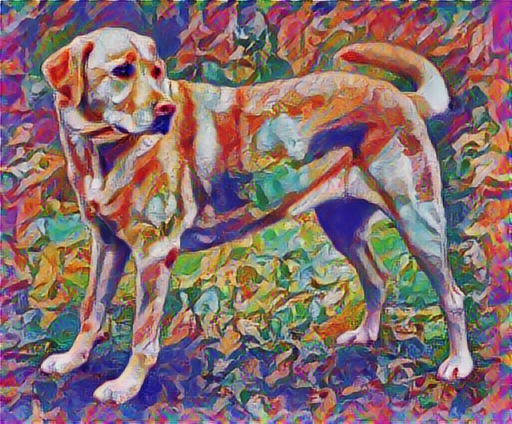

In [10]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [26]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [27]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665296),
 ('kuvasz', 0.036357515),
 ('Chesapeake_Bay_retriever', 0.02418277),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

In [28]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [32]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [33]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [34]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(' - 크기: ', output.numpy().shape)
    print(' - 최소값: ', output.numpy().min())
    print(' - 최대값: ', output.numpy().max())
    print(' - 평균: ', output.numpy().mean())
    print()

block1_conv1
 - 크기:  (1, 336, 512, 64)
 - 최소값:  0.0
 - 최대값:  835.5256
 - 평균:  33.97525

block2_conv1
 - 크기:  (1, 168, 256, 128)
 - 최소값:  0.0
 - 최대값:  4625.8857
 - 평균:  199.82687

block3_conv1
 - 크기:  (1, 84, 128, 256)
 - 최소값:  0.0
 - 최대값:  8789.239
 - 평균:  230.78099

block4_conv1
 - 크기:  (1, 42, 64, 512)
 - 최소값:  0.0
 - 최대값:  21566.135
 - 평균:  791.24005

block5_conv1
 - 크기:  (1, 21, 32, 512)
 - 최소값:  0.0
 - 최대값:  3189.2542
 - 평균:  59.179478



In [41]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

In [47]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[:self.num_style_layers])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value for style_name , value in zip(self.style_layers, style_outputs)}
        
        return{'content': content_dict, 'style':style_dict}

In [49]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('style: ')
for name, output in sorted(results['style'].items()):
   print(' - 크기: ', output.numpy().shape)
   print(' - 최소값: ', output.numpy().min())
   print(' - 최대값: ', output.numpy().max())
   print(' - 평균: ', output.numpy().mean())
   print()
   
print('Content: ')
for name, output in sorted(results['content'].items()):
   print(' - 크기: ', output.numpy().shape)
   print(' - 최소값: ', output.numpy().min())
   print(' - 최대값: ', output.numpy().max())
   print(' - 평균: ', output.numpy().mean())
   print()

style: 
 - 크기:  (1, 64, 64)
 - 최소값:  0.005522845
 - 최대값:  28014.555
 - 평균:  263.79022

 - 크기:  (1, 128, 128)
 - 최소값:  0.0
 - 최대값:  61479.484
 - 평균:  9100.949

 - 크기:  (1, 256, 256)
 - 최소값:  0.0
 - 최대값:  545623.44
 - 평균:  7660.976

 - 크기:  (1, 512, 512)
 - 최소값:  0.0
 - 최대값:  4320499.0
 - 평균:  134288.84

 - 크기:  (1, 512, 512)
 - 최소값:  0.0
 - 최대값:  110005.37
 - 평균:  1487.0378

Content: 
 - 크기:  (1, 422, 512, 64)
 - 최소값:  0.0
 - 최대값:  550.1154
 - 평균:  15.226082



In [51]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [52]:
image = tf.Variable(content_image)

In [53]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [54]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [55]:
style_weight = 1e-2
content_weight = 1e4

In [56]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    
    return loss                    

In [57]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

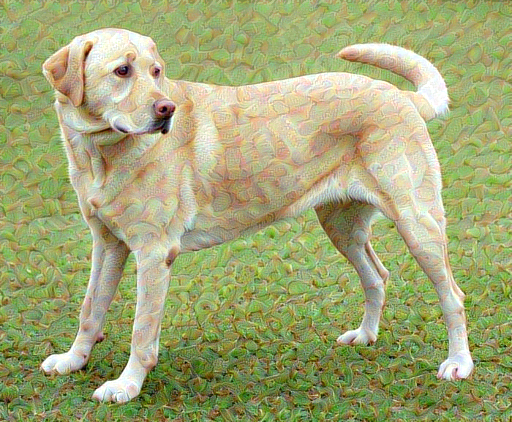

In [58]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)



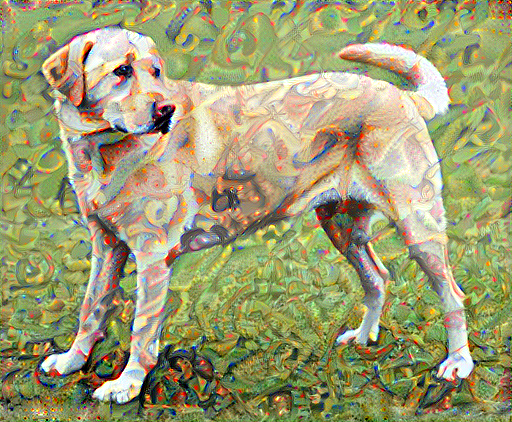

Training step: 1000
Elapsed time:46.04886746406555


In [59]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0 
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print('Training step: {}'.format(step))
    
end = time.time()
print('Elapsed time:{}'.format(end-start))


In [63]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    return x_var, y_var

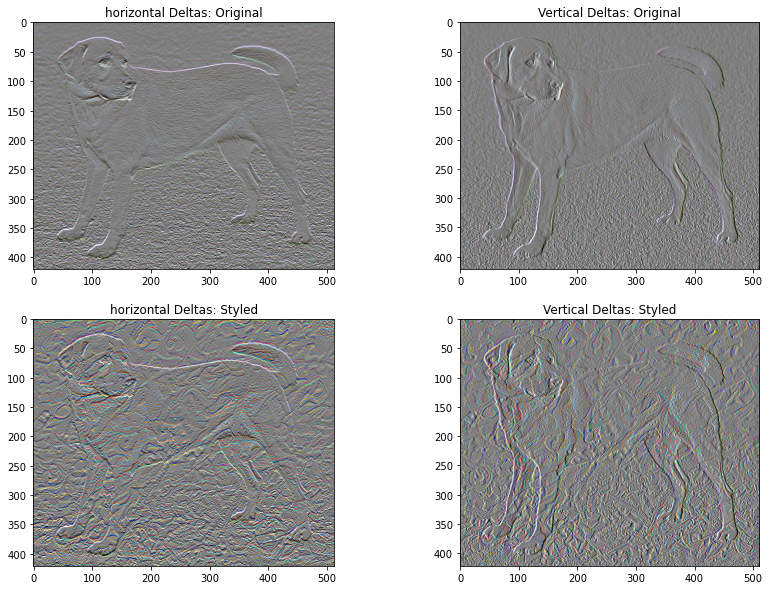

In [64]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), 'horizontal Deltas: Original')

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), 'horizontal Deltas: Styled')

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), 'Vertical Deltas: Styled')

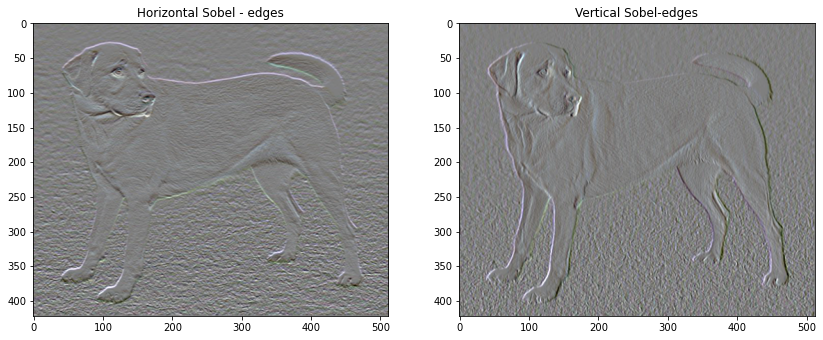

In [65]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), 'Horizontal Sobel - edges')
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), 'Vertical Sobel-edges')

In [66]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [79]:
total_variation_loss(image).numpy()

43371.33

In [80]:
tf.image.total_variation(image).numpy()

array([43371.33], dtype=float32)

In [83]:
total_variation_weight = 30

In [84]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image) 
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))    

In [85]:
image =tf.Variable(content_image)

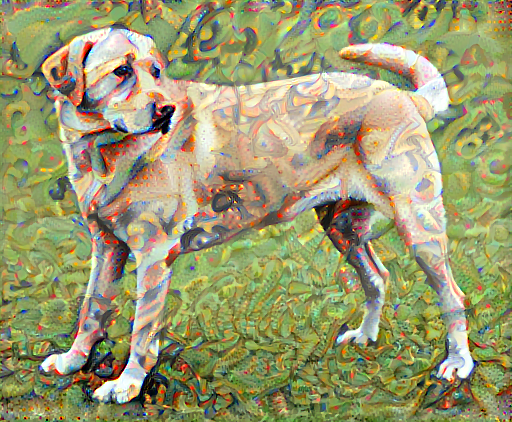

Training step: 1000
Elapsed time:47.65668201446533


In [86]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0 
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print('Training step: {}'.format(step))
    
end = time.time()
print('Elapsed time:{}'.format(end-start))